# 1D-CNN on random walk

First write dataloader for randomwalk sequence of length n. I am using the Ornstein-Uhlenbeck Process of some length, with starting point N(0,1). For more info, check the diffusion_sde.ipynb notebook.

Text(0, 0.5, 'state')

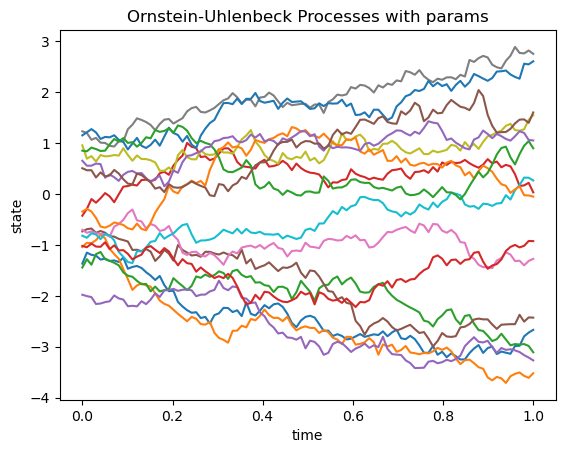

In [1]:
import torch
import torch.utils
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os

# Set the path to your LaTeX executable
# os.environ['PATH'] += os.pathsep + '/usr/bin/latex'
class OrnsteinUhlenbeckDataset():

    def __init__(self, length=1000, batch_size=16, T=100, theta=-0.5, mu=0.0, sigma=1.0):
        self.length = length
        self.batch_size = batch_size
        self.T = T                  
        self.theta = theta             
        self.mu = mu                   
        self.sigma = sigma
        
    def generate_ou_batch(self, batch_size, T, theta, mu, sigma):
        # Generates a batch of Ornstein-Uhlenbeck processes
        t = np.linspace(0,1,T)
        dt = t[1]-t[0]
        x = np.zeros((batch_size, len(t)))
        x[:,0] = np.random.randn(1,batch_size)

        for i in range(T-1):
            brownian_displ = np.random.normal(loc=0, scale=np.sqrt(dt), size=(1,batch_size))
            x[:,i+1] = x[:,i] + theta * (mu - x[:,i]) * dt + sigma * brownian_displ
        
        return torch.tensor(x, dtype=torch.float32)
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        batch = self.generate_ou_batch(
            batch_size = self.batch_size,
            T = self.T,
            theta = self.theta,
            mu = self.mu,
            sigma = self.sigma
            )
        
        return batch


BATCH_SIZE = 16
T = 100
dataset = OrnsteinUhlenbeckDataset(length=BATCH_SIZE, batch_size=BATCH_SIZE, T=T)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=1)

x = next(iter(dataloader))[0]

# Plot results
plt.plot(np.linspace(0,1,T),x.cpu().numpy().T)
plt.title(f"Ornstein-Uhlenbeck Processes with params")#: $theta={theta}, mu={mu}, sigma={sigma}$")
plt.xlabel("time")
plt.ylabel("state")

### Model definition - 1D CNN

Model has 897 parameters.


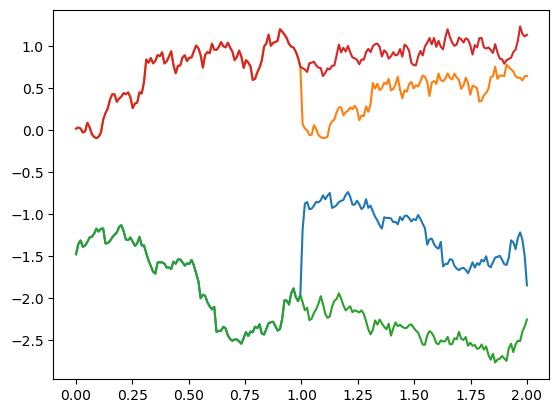

In [5]:
import torch.nn as nn

class TimeCNN(nn.Module):
    def __init__(self, n_channels=1, mid_channels=16):
        super(TimeCNN, self).__init__()
        
        self.doubleconv = nn.Sequential(
            nn.Conv1d(n_channels, mid_channels, kernel_size=3, padding=1),
            nn.Conv1d(mid_channels, mid_channels, kernel_size=3, padding=1),
            nn.Conv1d(mid_channels, n_channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return x + self.doubleconv(x)

BATCH_SIZE = 2
T = 200
dataset = OrnsteinUhlenbeckDataset(batch_size=BATCH_SIZE, T=T)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=1)
x = next(iter(dataloader))[0,:,None,:]
model = TimeCNN(n_channels=1, mid_channels=16)

print(f"Model has {sum(p.numel() for p in model.parameters())} parameters.")

t = torch.linspace(start=0,end=2, steps=T)
x_in = x[:,:,:T//2]
x_pred = torch.concat((x_in, model(x_in)),dim=2)

plt.plot(t, x_pred.squeeze(1).detach().numpy().transpose(), label="Prediction")
plt.plot(t, x.squeeze(1).detach().numpy().transpose(), label="GT")


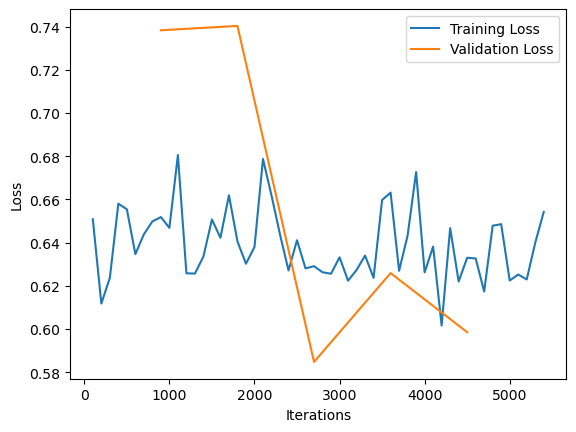

Validation loss did not increase for 3 epochs, keeping checkpoint of epoch 4


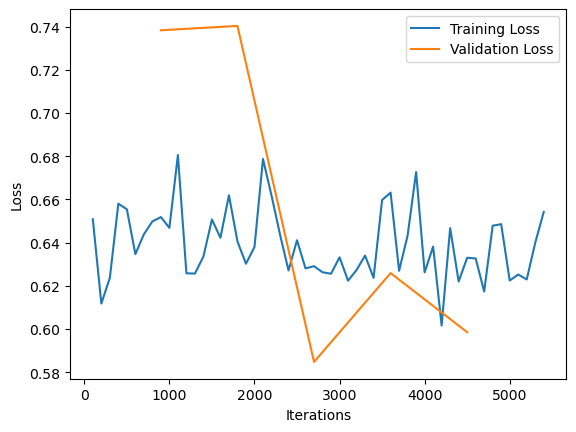

In [10]:
import torch.utils.data
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

BATCH_SIZE = 16
T = 200


x = next(iter(dataloader))[0,:,None,:]
model = TimeCNN(n_channels=1, mid_channels=16)
model.to(device)

train_dataset = OrnsteinUhlenbeckDataset(length=900, batch_size=BATCH_SIZE, T=T)
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1)
val_dataset   = OrnsteinUhlenbeckDataset(length=100, batch_size=1, T=T)
val_dataloader   = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=1)

optimizer = torch.optim.AdamW(params=model.parameters())
mse = torch.nn.MSELoss()

class LossPlot():

    def __init__(self):
        self.losses = {
            'training': {"iter":[], "value":[]}, 
            'validation': {"iter":[], "value":[]}}
        
        # Set up the plot
        plt.ion()
        self.fig, self.ax = plt.subplots()
        self.ax.set_ylabel('Loss')
        self.ax.set_xlabel('Iterations')
        self.training_line, = self.ax.plot([], [], label='Training Loss')
        self.validation_line, = self.ax.plot([], [], label='Validation Loss')
        self.ax.legend()

    def add_loss(self, value, iteration, loss_type='training'):
        assert loss_type in ['training', 'validation'],\
            'Loss type unknown, must be training or validation.'

        self.losses[loss_type]['iter'].append(iteration)
        self.losses[loss_type]['value'].append(value)

    def get_current_iteration(self, loss_type='training'):
        return self.losses[loss_type]['iter'][-1]

    def update_plot_ipynb(self):

        for key, line in zip(self.losses, [self.training_line, self.validation_line]):
            line.set_xdata(self.losses[key]['iter'])
            line.set_ydata(self.losses[key]['value'])

        self.ax.relim()
        self.ax.autoscale_view()

        clear_output(wait=True)
        display(self.fig)

plotter = LossPlot()

def train_one_epoch(epoch_number):

    model.train()
    accumulated_loss = 0.

    for idx, x in enumerate(train_dataloader):
        
        optimizer.zero_grad()

        x = x[0].to(device)
        x_in = x[:,None,:T//2]
        x_pred = model(x_in)
        loss = torch.nn.MSELoss()(x_pred, x[:,None,T//2:])
        
        loss.backward()
        optimizer.step()
        
        accumulated_loss += loss.detach()

        if idx%100==99:
            last_loss = accumulated_loss/100
            # print(f"Epoch: {epoch_number+1}, iteration: [{idx+1} / {len(train_dataloader)}], loss: {last_loss:.5f}")
            # update_plot(epoch_number * len(train_dataloader) + idx + 1, last_loss.item(), "training")
            plotter.add_loss(last_loss.item(), epoch_number * len(train_dataloader) + idx + 1)
            plotter.update_plot_ipynb()
            accumulated_loss = 0.0
    
    return last_loss

def validate():

    model.eval()
    avg_loss = 0.0

    for idx, x in enumerate(val_dataloader):

        with torch.no_grad():
            x = x[0].to(device)
            x_in = x[:,None,:T//2]
            x_pred = model(x_in)
            loss = torch.nn.MSELoss()(x_pred, x[:,None,T//2:])
            
            avg_loss += loss.detach()
    
    avg_loss /= len(val_dataloader)
    # update_plot(training_iterations[-1], avg_loss.item(), "validation")
    plotter.add_loss(avg_loss.item(), plotter.get_current_iteration(), "validation")
    
    return avg_loss


MAX_EPOCHS = 20
best_vloss = 1e6
patience = 3

for i in range(MAX_EPOCHS):

    model.train()
    training_loss = train_one_epoch(i)

    model.eval()
    validation_loss = validate()

    # print(f'\nEPOCH {i+1} FINISHED\nLOSS train {training_loss} valid {validation_loss}\n')

    if validation_loss < best_vloss:
        vloss_count = 0
        best_vloss = validation_loss
        model_path = 'ddpm_minimal.ckpt' # just saving best
        torch.save(model.state_dict(), model_path)
    else:
        vloss_count += 1
        if vloss_count == patience:
            print(f'Validation loss did not increase for {patience} epochs, keeping checkpoint of epoch {i-2+1}')
            break


Model has 897 parameters.


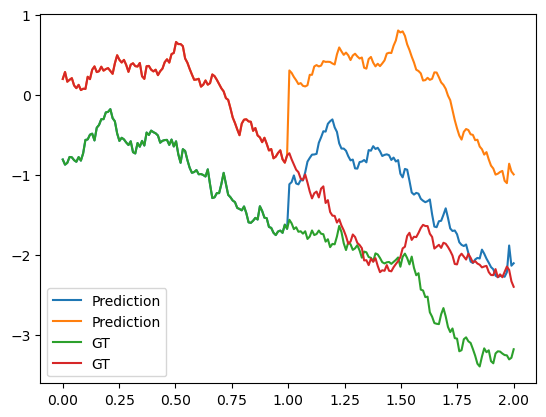

In [ ]:
BATCH_SIZE = 2
dataset = OrnsteinUhlenbeckDataset(batch_size=BATCH_SIZE, T=T)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=1)
x = next(iter(dataloader))[0,:,None,:].to(device)
# model = TimeCNN(n_channels=1, mid_channels=16)

print(f"Model has {sum(p.numel() for p in model.parameters())} parameters.")

t = torch.linspace(start=0,end=2, steps=T)
x_in = x[:,:,:T//2]
x_pred = torch.concat((x_in, model(x_in)),dim=2)

plt.plot(t, x_pred.squeeze(1).detach().cpu().numpy().transpose(), label="Prediction")
plt.plot(t, x.squeeze(1).detach().cpu().numpy().transpose(), label="GT")
plt.legend()